## Imports

In [ ]:
!pip install anytree

     |████████████████████████████████| 41 kB 546 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import math
import scipy
import statistics
import scipy.stats as st
import itertools

import matplotlib.pyplot as plt
from anytree import Node,LevelOrderIter

## Implementação


### Intervalo de confiança

In [ ]:
def mean_confidence_interval(data, confidence=0.96):
   a = 1.0 * np.array(data)
   n = len(a)
   m, se = np.mean(a), scipy.stats.sem(a)
   h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
   return m, m-h, m+h

### Classe Event

In [ ]:
class Event:
  def __init__(self, time, isArrival = True):
    self.time = time
    self.isArrival = isArrival

  def __gt__(self, other):
    return self.time > other.time

  def __ge__(self, other):
    return self.time >= other.time

  def __lt__(self, other):
    return self.time < other.time

  def __le__(self, other):
    return self.time <= other.time

  def __eq__(self, other):
    return self.time == other.time

  def __ne__(self, other):
    return self.time != other.time

  def __sub__(self, other):
    return self.time - other.time

### Classe EventList

In [ ]:
def sort_by_time(e):
  return e.time

class EventList:
  def __init__(self):
    self.list = []

  def pushSorted(self, event):
    self.list.append(event)
    self.list.sort(key=sort_by_time)

  def pop(self):
    return self.list.pop(0)

  def length(self):
    return len(self.list)

  def isEmpty(self):
    return len(self.list) == 0

### Classe Client

In [ ]:
class Client:
  id_iter = itertools.count()

  def __init__(self, arrivalEvent):
    self.id = next(Client.id_iter)
    self.arrivalEvent = arrivalEvent
    self.serviceEvent = Event(time=-1, isArrival=False)
    self.executionTime = -1

  def __str__(self):
    return f'Client[{self.id}] - Arrival: {self.arrivalEvent.time}, Served: {self.serviceEvent.time}, executionTime: {self.executionTime}'

  def isFinished(self):
    return self.executionTime > 0

  def setServiceEvent(self, event):
    self.serviceEvent = event
    self.executionTime =  self.serviceEvent - self.arrivalEvent


### Classe Queue

In [ ]:
class Queue:
  def __init__(self, arrivalRate, serviceRate):
    self.arrivalRate = arrivalRate
    self.serviceRate = serviceRate
    self.list = []
    self.allClients = []
    self.allServedClients = []

    self.currentClient = None
    self.currentTree = []
    self.trees = []

  def push(self, client):
    self.list.append(client)
    self.allClients.append(client)

  def pop(self):
    client = self.list.pop(0)
    self.allServedClients.append(client)
    return client

  def length(self):
    return len(self.list)

  def isEmpty(self):
    return len(self.list) == 0

  def handleEvent(self, eventList, isExponentialServices=True):
    nextEvent = eventList.pop()

    currentTime = nextEvent.time

    if nextEvent.isArrival:
      client = Client(nextEvent)
      self.push(client)

      if self.currentClient is None:
        self.currentClient = client
        self.currentTree.append(self.currentClient.id)
      else:
        edge = (self.currentClient.id,client.id)
        self.currentTree.append(edge)

      time = currentTime + np.random.exponential(1/self.arrivalRate)
      nextArrival = Event(time=time, isArrival=True)
      eventList.pushSorted(nextArrival)

      if self.length() == 1:
        deltaTime =  np.random.exponential(1/self.serviceRate) if isExponentialServices else 1/self.serviceRate
        eventTime = currentTime + deltaTime
        nextService = Event(time=eventTime, isArrival=False)
        eventList.pushSorted(nextService)
    else:
      client = self.pop()
      client.setServiceEvent(nextEvent)

      if self.isEmpty():
        self.currentClient = None
      else:
        self.currentClient = self.list[0]

      if self.length() > 0:
        deltaTime =  np.random.exponential(1/self.serviceRate) if isExponentialServices else 1/self.serviceRate
        eventTime = currentTime + deltaTime
        nextService = Event(time=eventTime, isArrival=False)
        eventList.pushSorted(nextService)
      else:
        self.trees.append(self.currentTree)
        self.currentTree = []

    timeUntilNextEvent = eventList.list[0] - nextEvent

    return (client.id, nextEvent.time, nextEvent.isArrival, self.length(), timeUntilNextEvent)

### M/M/1

In [ ]:
def MM1(Lambda, Mu, maxEvents=10_000):
  currentTime = 0
  eventList = EventList()
  eventList.pushSorted(Event(time=np.random.exponential(1/Lambda), isArrival=True))

  queue = Queue(Lambda, Mu)
  timeline = []

  while len(timeline) < maxEvents:
    log = queue.handleEvent(eventList)

    timeline.append(log)

  return queue, eventList, timeline

In [ ]:
# queue, events, timeline = MM1(1, 10, 99)

### M/D/1

In [ ]:
def MD1(Lambda, Mu, maxEvents=10_000):
  currentTime = 0
  eventList = EventList()
  eventList.pushSorted(Event(time=np.random.exponential(1/Lambda), isArrival=True))

  queue = Queue(Lambda, Mu)
  timeline = []

  while len(timeline) < maxEvents:
    log = queue.handleEvent(eventList, isExponentialServices=False)

    timeline.append(log)

  return queue, eventList, timeline

In [ ]:
# queue, events, timeline = MD1(1, 10, 99)

### Tratamento das Saídas

#### Saida Clientes

In [ ]:
def clients_to_dataframe(clients):
  pre_process_client_data = lambda x: {
    'ID': x.id,
    'ArrivalTime': x.arrivalEvent.time,
    'ServiceTime': -1 if not x.serviceEvent else x.serviceEvent.time,
    'ExecutionTime': x.executionTime
  }
  data = map(pre_process_client_data, clients)

  df_data = {'ID':[],
            'ArrivalTime':[],
            'ServiceTime':[],
            'ExecutionTime':[]}
  for i in data:
    df_data['ID'].append(i['ID'])
    df_data['ArrivalTime'].append(i['ArrivalTime'])
    df_data['ServiceTime'].append(i['ServiceTime'])
    df_data['ExecutionTime'].append(i['ExecutionTime'])

  return pd.DataFrame(data=df_data)

In [ ]:
# clients_to_dataframe(queue.allClients)

#### Saida Timeline

In [ ]:
def timeline_to_dataframe(timeline):
  pre_process_data = lambda x: {
    'ClientID': x[0],
    'EventTime': x[1],
    'EventType':  'Arrival' if x[2] else 'Service',
    'QueueSizeAfterEvent': x[3],
    'timeUntilNextEvent': x[4],
  }
  timeline_data = map(pre_process_data,timeline)

  df_timeline = {
      'ClientID':[],
      'EventTime':[],
      'EventType':[],
      'QueueSizeAfterEvent':[],
      'timeUntilNextEvent':[]
    }

  for i in timeline_data:
    df_timeline['ClientID'].append(i['ClientID'])
    df_timeline['EventTime'].append(i['EventTime'])
    df_timeline['EventType'].append(i['EventType'])
    df_timeline['QueueSizeAfterEvent'].append(i['QueueSizeAfterEvent'])
    df_timeline['timeUntilNextEvent'].append(i['timeUntilNextEvent'])

  return pd.DataFrame(data=df_timeline)

In [ ]:
# df = timeline_to_dataframe(timeline)
# df['EventType'] = df['EventType'].map(lambda x: 'Arrival' if x else 'Service')
# pd.set_option('display.max_rows', 50)
# df['QueueSizeAfterEvent'].value_counts()
#.loc[df['ClientID'] == 1]

# df.QueueSizeAfterEvent.values_count()
# g = df.groupby(['QueueSizeAfterEvent'])['timeUntilNextEvent'].sum()

# g


In [ ]:
# df_arrival = df.loc[df['EventType']=='Arrival']
# df_service = df.loc[df['EventType']=='Service']

# df_merged = pd.merge(df_arrival,df_service,how='inner',on='ClientID')

# df_merged['WaitingTime'] = df_merged['EventTime_y'] - df_merged['EventTime_x']

# df_merged

#### Saída Árvore

##### Formantando as árvores

In [ ]:
def formatTree(queueTrees):
  nodeHashTable = {}
  formattedTrees = []
  for tree in queueTrees:
    for i in tree:
      if type(i) == int:
        root = Node(i)
        nodeHashTable[i] = root
      else:
        nodeHashTable[i[1]] = Node(i[1],parent=nodeHashTable[i[0]])
    formattedTrees.append(root)
  return formattedTrees

##### Funções Auxiliares

In [ ]:
# Gera uma lista de graus de saida de todos os vertices de todos as árvores dado
# uma lista de árvores
def _getDegreeList(formattedTrees):
  meanDegreeList = []
  for tree in formattedTrees:
    for vertice in LevelOrderIter(tree):
      meanDegreeList.append(len(vertice.children))
  return np.array(meanDegreeList)

# Gera uma lista contendo todos os ID de clientes que estão presentes em
# uma determinada árvore
def _treeToList(tree):
  return [vertice.name for vertice in LevelOrderIter(tree)]

##### Fração de árvores finitas

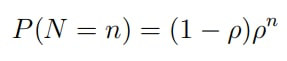

In [ ]:
def probabilityToRemainFiniteTrees(Ro):
  return (1-Ro) if (1-Ro)>0 else 0

##### Grau médio de saida de uma simulação

In [ ]:
def meanDegree(formattedTrees):
  degreeList = _getDegreeList(formattedTrees)
  return degreeList.mean()

##### Média do grau máximo de saída

In [ ]:
#
def maxDegreeMean(formattedTrees):
  maxDegreeList = []
  for tree in formattedTrees:
    maxDegree = -1
    for vertice in LevelOrderIter(tree):

      if len(vertice.children)>maxDegree:
        maxDegree = len(vertice.children)
    maxDegreeList.append(maxDegree)

  return sum(maxDegreeList)/len(maxDegreeList)

##### Grau médio de saída da raiz

In [ ]:
def rootMeanDegree(formattedTrees):
  rootCount = len(formattedTrees)
  degreeCount = 0
  for root in formattedTrees:
    degreeCount += len(root.children)
  return degreeCount/rootCount

##### Altura Média das árvores

In [ ]:
def meanRootHeight(formattedTrees):
  meanList = []
  for node in formattedTrees:
    meanList.append(node.height)
  return sum(meanList)/len(meanList)

##### Média de altura dos nós das árvores

In [ ]:
def meanVerticesHeight(formattedTrees):
  meanList = []
  for tree in formattedTrees:
    for vertice in LevelOrderIter(tree):
      meanList.append(vertice.height)
  return sum(meanList)/len(meanList)

##### Média de duração do período ocupado

In [ ]:
def busyPeriodMeanTime(formattedTrees,df_timeline):
  meanList = []
  for tree in formattedTrees:
    allVertices = _treeToList(tree)
    root, lastLeaf = allVertices[0],allVertices[-1]
    rootArrivalTime = df_timeline.loc[(df_timeline['EventType']=='Arrival')&
                                      (df_timeline['ClientID']==root),'EventTime'].iloc[0]
    lastLeafServiceTime = df_timeline.loc[(df_timeline['EventType']=='Service')&
                                          (df_timeline['ClientID']==lastLeaf),'EventTime'].iloc[0]

    meanList.append(lastLeafServiceTime-rootArrivalTime)
  return sum(meanList)/len(meanList)

##### Média de clientes servidos por periodo ocupado

In [ ]:
def clientsServedByBusyPeriodMean(formattedTrees):
  meanList = []
  for tree in formattedTrees:
    meanList.append(len(_treeToList(tree)))
  return sum(meanList)/len(meanList)

### Rodadas


In [ ]:
def getRounds(Lambda, Mu, system, maxEvents=10_000, roundsQuantity=10):
  timeline_dfs = []
  clients_dfs = []
  _trees = []

  for i in range(roundsQuantity):
    queue, _, timeline = system(Lambda, Mu, maxEvents)

    clients_df = clients_to_dataframe(queue.allServedClients)
    clients_dfs.append(clients_df)

    timeline_df = timeline_to_dataframe(timeline)
    timeline_dfs.append(timeline_df)

    _trees.append(formatTree(queue.trees))
  return [clients_dfs, timeline_dfs], _trees

In [ ]:
def graphs_from_rounds(rounds):
  clients_dfs, timeline_dfs = rounds
  N_ROUNDS = len(timeline_dfs)

  executionTimesTotal = np.array([])
  executionTimes = []
  queueSizeTimes = []

  for i in range(N_ROUNDS):
    executionTimes.append(clients_dfs[i].ExecutionTime.mean())

    executionTimesTotal = np.concatenate((executionTimesTotal, list(clients_dfs[i].round(4).ExecutionTime)))

    totalTime = timeline_dfs[i].groupby(["QueueSizeAfterEvent"])["timeUntilNextEvent"].sum().sum()

    for (idx, time) in enumerate(timeline_dfs[i].groupby(["QueueSizeAfterEvent"])["timeUntilNextEvent"].sum()):
      if(idx + 1 > len(queueSizeTimes)):
        queueSizeTimes.append([0]*N_ROUNDS)
      queueSizeTimes[idx][i] = time/totalTime


  queueSizeTimesWithConfidenceInterval = list(map(lambda x: mean_confidence_interval(x),queueSizeTimes))

  df = pd.DataFrame(columns=['Média', 'Intervalo de Confiança (limite inferior)','Intervalo de Confiança (limite superior)'])
  for i, val in enumerate(queueSizeTimesWithConfidenceInterval):
    m, li, ls = val
    df.loc[f'Estado {i}'] = ('{:.6}'.format(m).rstrip('0').rstrip('.'),
                             '{:.6}'.format(li).rstrip('0').rstrip('.'),
                             '{:.6}'.format(ls).rstrip('0').rstrip('.'))

  PDFqueueSizeTimesBottom = list(map(lambda x: x[1],queueSizeTimesWithConfidenceInterval))
  PDFqueueSizeTimesTop = list(map(lambda x: x[2],queueSizeTimesWithConfidenceInterval))
  PDFqueueSizeTimesMean = list(map(lambda x: x[0],queueSizeTimesWithConfidenceInterval))

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))


  ax1.plot(PDFqueueSizeTimesBottom, color='blue')
  ax1.plot(PDFqueueSizeTimesTop, color='red')
  ax1.plot(PDFqueueSizeTimesMean, color='green')
  ax1.set_title("PDF Quantidade de clientes na fila")
  ax1.set_xlabel("quantidade")
  ax1.legend(['bottom', 'top', 'mean'])

  CDFqueueSizeTimesBottom = np.cumsum(PDFqueueSizeTimesBottom)
  CDFqueueSizeTimesTop = np.cumsum(PDFqueueSizeTimesTop)
  CDFqueueSizeTimesMean = np.cumsum(PDFqueueSizeTimesMean)


  ax2.plot(CDFqueueSizeTimesBottom, color='blue')
  ax2.plot(CDFqueueSizeTimesTop, color='red')
  ax2.plot(CDFqueueSizeTimesMean, color='green')
  ax2.set_title("CDF Quantidade de clientes na fila")
  ax2.set_xlabel("quantidade")
  ax2.legend(['bottom', 'top', 'mean'])
  plt.show()


  print(f'\n\nTempos de espera:\n')

  executionTimesTotal.sort()

  mciExecutionTimes = mean_confidence_interval(executionTimes)

  print(f'Tempo médio de espera: 95%[{mciExecutionTimes[1]}, {mciExecutionTimes[2]}], Média: {mciExecutionTimes[0]}\n')


  executionTimesCount = len(executionTimesTotal)

  PDFexecutionTimesTotal = [1/executionTimesCount] * executionTimesCount

  CDFexecutionTimesTotal = np.cumsum(PDFexecutionTimesTotal)


  plt.plot(executionTimesTotal, CDFexecutionTimesTotal, color='blue')
  plt.title("CDF Tempo de espera")
  plt.xlabel("Tempo de espera")
  plt.legend(['probabilidade cumulativa'])
  plt.show()

  print('\nDistribuição estacionária com intervalo de confiança:')
  return df

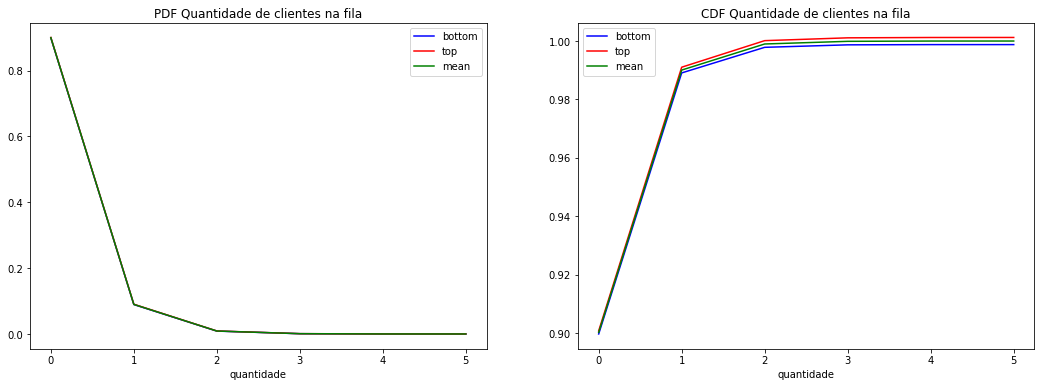



Tempos de espera:

Tempo médio de espera: 95%[0.11056149434925625, 0.11144970712916172], Média: 0.11100560073920898



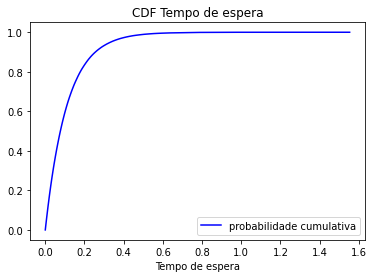


Distribuição estacionária com intervalo de confiança:


,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,0.900203,0.899667,0.900738
Estado 1,0.0898545,0.0894108,0.0902982
Estado 2,0.0089321,0.00876752,0.00909668
Estado 3,0.00090681,0.000850324,0.000963296
Estado 4,9.55268e-05,7.71775e-05,0.000113876
Estado 5,8.41335e-06,4.58711e-06,1.22396e-05


In [ ]:
rounds, _ = getRounds(Lambda=1, Mu=10, system=MM1, maxEvents=100_000, roundsQuantity=10)

graphs_from_rounds(rounds)

In [ ]:
def tree_graphs_from_rounds(rounds,trees):
  clients_dfs, timeline_dfs = rounds
  N_ROUNDS = len(timeline_dfs)

  executionTimesTotal = np.array([])
  executionTimes = []
  queueSizeTimes = []
  degreeList = pd.Series([])

  for i in range(N_ROUNDS):
    degreeList = pd.concat([degreeList,pd.Series(_getDegreeList(trees[i]))])

  plt.hist(degreeList,bins=degreeList.unique())
  plt.show()

  degreeValCounts = degreeList.value_counts()
  pdf = degreeValCounts.values / sum(degreeValCounts.values)
  cdf = np.cumsum(pdf)

  plt.plot(pdf, color='red',label='PDF')
  plt.plot(cdf, color='green',label='CDF')
  plt.title("PDF & CDF Distribuição de saidas")
  plt.legend()
  plt.show()

## Q4

### Q4.0

##### M/M/1: ρ = 0.1, λ = 1, µ = 10

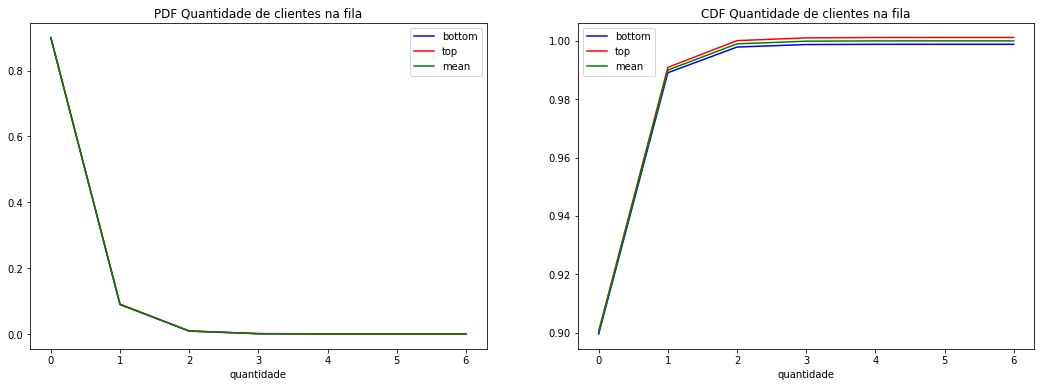



Tempos de espera:

Tempo médio de espera: 95%[0.11061025356185138, 0.11140486703355564], Média: 0.1110075602977035



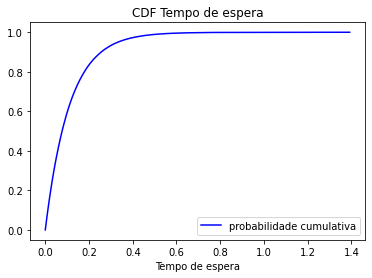


Distribuição estacionária com intervalo de confiança:


,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,0.900007,0.899517,0.900497
Estado 1,0.0899954,0.089569,0.0904217
Estado 2,0.00898572,0.00880287,0.00916858
Estado 3,0.000902757,0.000856333,0.00094918
Estado 4,9.83889e-05,7.77058e-05,0.000119072
Estado 5,9.40377e-06,5.92584e-06,1.28817e-05
Estado 6,1.3782e-06,-2.429e-07,2.9993e-06


In [ ]:
rounds, _ = getRounds(Lambda=1, Mu=10, system=MM1, maxEvents=100_000, roundsQuantity=10)

graphs_from_rounds(rounds)

##### M/M/1: ρ = 0.1, λ = 2, µ = 20

                 Média  Intervalo de Confiança (limite inferior)  \
Estado 0  9.004129e-01                              8.998979e-01   
Estado 1  8.964629e-02                              8.920223e-02   
Estado 2  8.965585e-03                              8.842528e-03   
Estado 3  8.817336e-04                              8.459012e-04   
Estado 4  8.555475e-05                              7.013578e-05   
Estado 5  7.570383e-06                              3.491066e-06   
Estado 6  3.213350e-07                             -9.944001e-08   

          Intervalo de Confiança (limite superior)  
Estado 0                              9.009280e-01  
Estado 1                              9.009036e-02  
Estado 2                              9.088642e-03  
Estado 3                              9.175661e-04  
Estado 4                              1.009737e-04  
Estado 5                              1.164970e-05  
Estado 6                              7.421101e-07  


Quantidade de clientes na fil

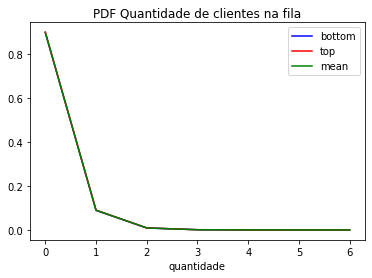

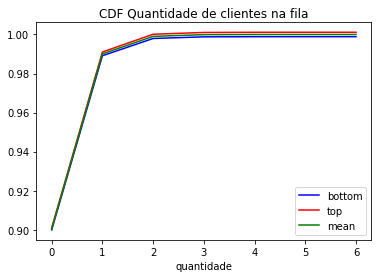



Tempos de espera:

Tempo médio de espera: 95%[0.055187298699542524, 0.05555506078427546], Média: 0.05537117974190899



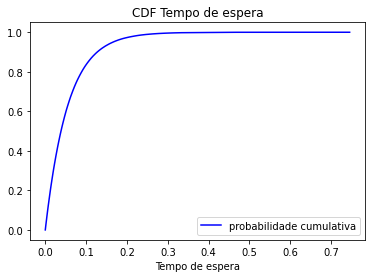

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,9.004129e-01,8.998979e-01,9.009280e-01
Estado 1,8.964629e-02,8.920223e-02,9.009036e-02
Estado 2,8.965585e-03,8.842528e-03,9.088642e-03
Estado 3,8.817336e-04,8.459012e-04,9.175661e-04
Estado 4,8.555475e-05,7.013578e-05,1.009737e-04
Estado 5,7.570383e-06,3.491066e-06,1.164970e-05
Estado 6,3.213350e-07,-9.944001e-08,7.421101e-07


In [ ]:
rounds, _ = getRounds(Lambda=2, Mu=20, system=MM1, maxEvents=100_000, roundsQuantity=10)

graphs_from_rounds(rounds)

##### M/M/1: ρ = 1.2, λ = 12, µ = 10

A saída de streaming foi truncada nas últimas 5000 linhas.
Estado 4495: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4496: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4497: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4498: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4499: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4500: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4501: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4502: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4503: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4504: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4505: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4506: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4507: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4508: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4509: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4510: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4511: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4512: Menor[0.000] Média[0.000] Maior[0.000]
Estad

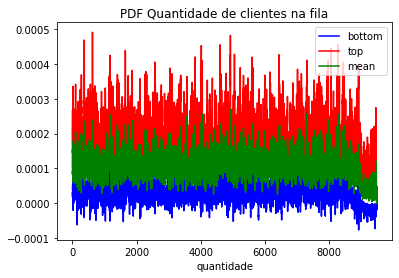

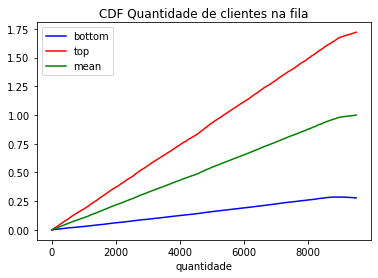



Tempos de espera:

Tempo médio de espera: 95%[369.9451808951359, 394.42114729913885], Média: 382.18316409713736



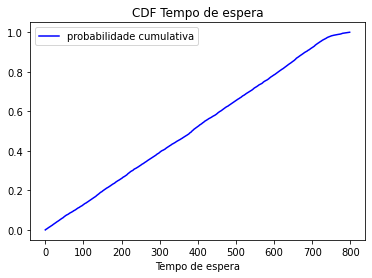

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,9.129166e-05,2.915226e-05,0.000153
Estado 1,8.281441e-05,2.076498e-05,0.000145
Estado 2,9.608367e-05,2.610977e-05,0.000166
Estado 3,1.268918e-04,2.332478e-05,0.000230
Estado 4,1.304179e-04,1.739921e-05,0.000243
...,...,...,...
Estado 9488,1.441913e-05,-2.016430e-05,0.000049
Estado 9489,5.504568e-06,-7.697814e-06,0.000019
Estado 9490,5.679357e-07,-7.942246e-07,0.000002
Estado 9491,3.054305e-06,-4.271265e-06,0.000010


In [ ]:
rounds, _ = getRounds(Lambda=12, Mu=10, system=MM1, maxEvents=100_000, roundsQuantity=10)

graphs_from_rounds(rounds)

##### M/M/1: ρ = 2, λ = 20, µ = 10

A saída de streaming foi truncada nas últimas 5000 linhas.
Estado 28574: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28575: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28576: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28577: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28578: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28579: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28580: Menor[-0.000] Média[0.000] Maior[0.000]
Estado 28581: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28582: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28583: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28584: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28585: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28586: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28587: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28588: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28589: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28590: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28591: Menor[0.000] Média[0.000]

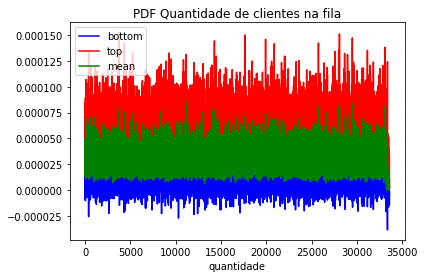

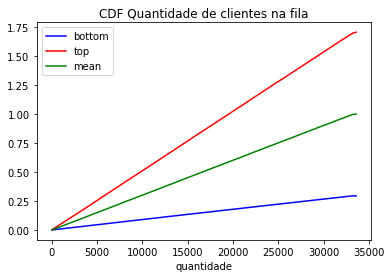



Tempos de espera:

Tempo médio de espera: 95%[826.9717811776762, 837.9072545220878], Média: 832.439517849882



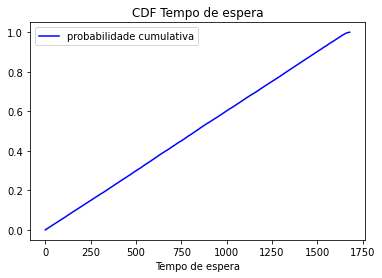

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,0.000046,0.000013,0.000079
Estado 1,0.000040,0.000015,0.000066
Estado 2,0.000022,0.000006,0.000038
Estado 3,0.000036,0.000011,0.000061
Estado 4,0.000035,0.000004,0.000066
...,...,...,...
Estado 33567,0.000010,-0.000015,0.000035
Estado 33568,0.000006,-0.000008,0.000019
Estado 33569,0.000007,-0.000010,0.000024
Estado 33570,0.000004,-0.000006,0.000015


In [ ]:
rounds, _ = getRounds(Lambda=20, Mu=10, system=MM1, maxEvents=100000, roundsQuantity=10)

graphs_from_rounds(rounds)

##### M/D/1: ρ = 0.1, λ = 1, µ = 10

                 Média  Intervalo de Confiança (limite inferior)  \
Estado 0  8.999977e-01                              8.996600e-01   
Estado 1  9.465795e-02                              9.435832e-02   
Estado 2  5.135142e-03                              5.045101e-03   
Estado 3  2.037487e-04                              1.860663e-04   
Estado 4  5.403062e-06                              2.714892e-06   
Estado 5  7.498183e-08                             -4.580133e-08   

          Intervalo de Confiança (limite superior)  
Estado 0                              9.003353e-01  
Estado 1                              9.495757e-02  
Estado 2                              5.225182e-03  
Estado 3                              2.214311e-04  
Estado 4                              8.091232e-06  
Estado 5                              1.957650e-07  


Quantidade de clientes na fila:


Distribuição estacionária com intervalo de confiança:
Estado 0: Menor[0.900] Média[0.900] Maior[0.900]
Estado 1: Men

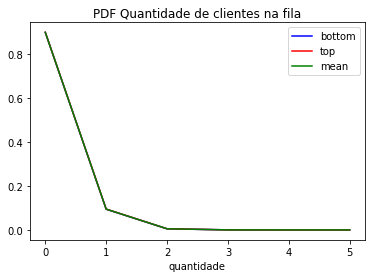

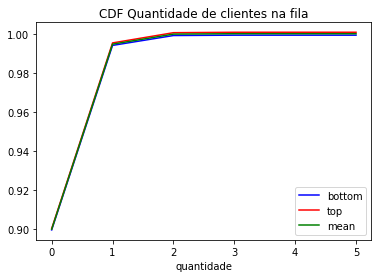



Tempos de espera:

Tempo médio de espera: 95%[0.10546037904168311, 0.10565701097010567], Média: 0.10555869500589439



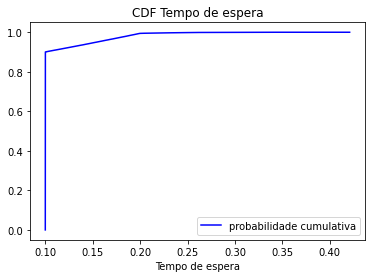

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,8.999977e-01,8.996600e-01,9.003353e-01
Estado 1,9.465795e-02,9.435832e-02,9.495757e-02
Estado 2,5.135142e-03,5.045101e-03,5.225182e-03
Estado 3,2.037487e-04,1.860663e-04,2.214311e-04
Estado 4,5.403062e-06,2.714892e-06,8.091232e-06
Estado 5,7.498183e-08,-4.580133e-08,1.957650e-07


In [ ]:
rounds, _ = getRounds(Lambda=1, Mu=10, system=MD1, maxEvents=100000, roundsQuantity=10)

graphs_from_rounds(rounds)

##### M/D/1: ρ = 0.1, λ = 2, µ = 20

                 Média  Intervalo de Confiança (limite inferior)  \
Estado 0  9.000876e-01                              8.998011e-01   
Estado 1  9.460540e-02                              9.435059e-02   
Estado 2  5.104548e-03                              5.047359e-03   
Estado 3  1.951443e-04                              1.870758e-04   
Estado 4  7.220176e-06                              5.500631e-06   
Estado 5  1.040264e-07                             -1.288387e-07   

          Intervalo de Confiança (limite superior)  
Estado 0                              9.003740e-01  
Estado 1                              9.486020e-02  
Estado 2                              5.161737e-03  
Estado 3                              2.032128e-04  
Estado 4                              8.939720e-06  
Estado 5                              3.368916e-07  


Quantidade de clientes na fila:


Distribuição estacionária com intervalo de confiança:
Estado 0: Menor[0.900] Média[0.900] Maior[0.900]
Estado 1: Men

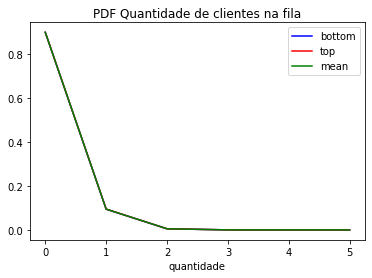

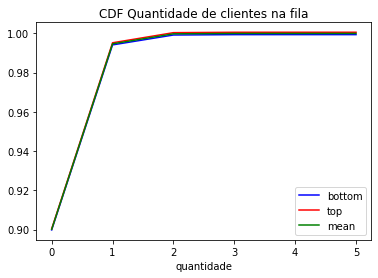



Tempos de espera:

Tempo médio de espera: 95%[0.05273153933840396, 0.05279005229801335], Média: 0.05276079581820865



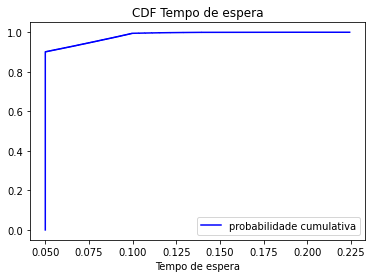

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,9.000876e-01,8.998011e-01,9.003740e-01
Estado 1,9.460540e-02,9.435059e-02,9.486020e-02
Estado 2,5.104548e-03,5.047359e-03,5.161737e-03
Estado 3,1.951443e-04,1.870758e-04,2.032128e-04
Estado 4,7.220176e-06,5.500631e-06,8.939720e-06
Estado 5,1.040264e-07,-1.288387e-07,3.368916e-07


In [ ]:
rounds, _ = getRounds(Lambda=2, Mu=20, system=MD1, maxEvents=100000, roundsQuantity=10)

graphs_from_rounds(rounds)

##### M/D/1: ρ = 1.2, λ = 12, µ = 10

A saída de streaming foi truncada nas últimas 5000 linhas.
Estado 4352: Menor[-0.000] Média[0.000] Maior[0.000]
Estado 4353: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4354: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4355: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4356: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4357: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4358: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4359: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4360: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4361: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4362: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4363: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4364: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4365: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4366: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4367: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4368: Menor[0.000] Média[0.000] Maior[0.000]
Estado 4369: Menor[0.000] Média[0.000] Maior[0.000]
Esta

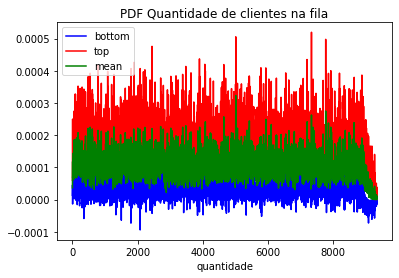

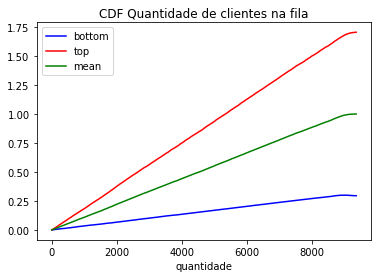



Tempos de espera:

Tempo médio de espera: 95%[368.6178126950558, 384.3305497636768], Média: 376.4741812293663



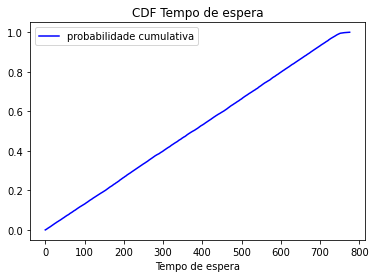

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,3.644821e-05,1.314209e-05,5.975433e-05
Estado 1,8.230284e-05,3.985320e-05,1.247525e-04
Estado 2,7.385153e-05,3.442990e-05,1.132732e-04
Estado 3,7.940754e-05,4.515201e-05,1.136631e-04
Estado 4,8.797515e-05,1.801324e-05,1.579371e-04
...,...,...,...
Estado 9345,6.373869e-06,-8.913480e-06,2.166122e-05
Estado 9346,1.147939e-05,-1.605324e-05,3.901202e-05
Estado 9347,9.361232e-06,-1.309113e-05,3.181360e-05
Estado 9348,2.292624e-06,-3.206099e-06,7.791346e-06


In [ ]:
rounds, _ = getRounds(Lambda=12, Mu=10, system=MD1, maxEvents=100000, roundsQuantity=10)

graphs_from_rounds(rounds)

##### M/D/1: ρ = 2, λ = 20, µ = 10

A saída de streaming foi truncada nas últimas 5000 linhas.
Estado 28565: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28566: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28567: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28568: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28569: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28570: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28571: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28572: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28573: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28574: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28575: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28576: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28577: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28578: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28579: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28580: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28581: Menor[0.000] Média[0.000] Maior[0.000]
Estado 28582: Menor[0.000] Média[0.000] 

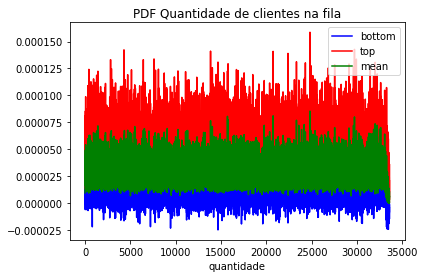

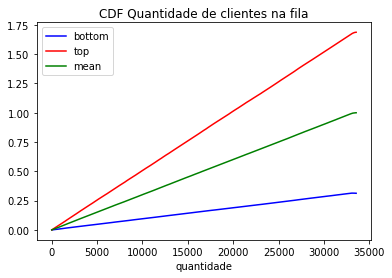



Tempos de espera:

Tempo médio de espera: 95%[828.5607450842667, 835.4340250319017], Média: 831.9973850580842



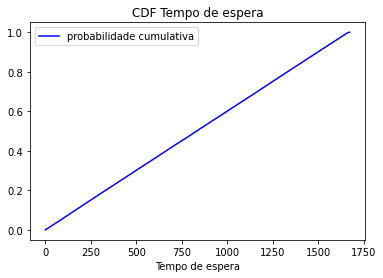

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,9.403285e-06,0.000005,0.000013
Estado 1,1.809085e-05,0.000005,0.000031
Estado 2,2.652605e-05,0.000006,0.000047
Estado 3,1.943242e-05,0.000008,0.000031
Estado 4,3.856481e-05,0.000011,0.000067
...,...,...,...
Estado 33558,9.001792e-07,-0.000001,0.000003
Estado 33559,5.313700e-06,-0.000007,0.000018
Estado 33560,1.023779e-05,-0.000014,0.000035
Estado 33561,1.063633e-05,-0.000015,0.000036


In [ ]:
rounds, _ = getRounds(Lambda=20, Mu=10, system=MD1, maxEvents=100000, roundsQuantity=10)

graphs_from_rounds(rounds)

                  Média  Intervalo de Confiança (limite inferior)  \
Estado 0   1.006599e-01                              9.991836e-02   
Estado 1   1.466003e-01                              1.454237e-01   
Estado 2   1.377039e-01                              1.366751e-01   
Estado 3   1.150845e-01                              1.143033e-01   
Estado 4   9.376664e-02                              9.305270e-02   
Estado 5   7.627056e-02                              7.596146e-02   
Estado 6   6.208027e-02                              6.170601e-02   
Estado 7   5.030915e-02                              4.980194e-02   
Estado 8   4.080567e-02                              4.024822e-02   
Estado 9   3.309701e-02                              3.264444e-02   
Estado 10  2.676879e-02                              2.640442e-02   
Estado 11  2.170130e-02                              2.121490e-02   
Estado 12  1.764457e-02                              1.726388e-02   
Estado 13  1.444833e-02           

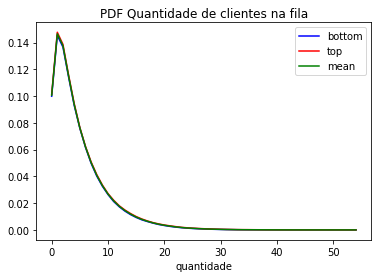

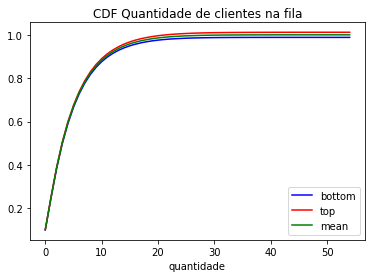



Tempos de espera:

Tempo médio de espera: 95%[0.541897594271133, 0.5536543601805419], Média: 0.5477759772258375



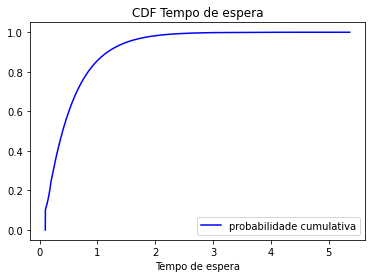

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,1.006599e-01,9.991836e-02,1.014014e-01
Estado 1,1.466003e-01,1.454237e-01,1.477769e-01
Estado 2,1.377039e-01,1.366751e-01,1.387327e-01
Estado 3,1.150845e-01,1.143033e-01,1.158657e-01
Estado 4,9.376664e-02,9.305270e-02,9.448059e-02
Estado 5,7.627056e-02,7.596146e-02,7.657966e-02
Estado 6,6.208027e-02,6.170601e-02,6.245453e-02
Estado 7,5.030915e-02,4.980194e-02,5.081636e-02
Estado 8,4.080567e-02,4.024822e-02,4.136313e-02
Estado 9,3.309701e-02,3.264444e-02,3.354958e-02


In [ ]:
rounds,_ = getRounds(Lambda=9, Mu=10, system=MD1, maxEvents=1000000, roundsQuantity=10)

graphs_from_rounds(rounds)

### Q4.1

#### M/M/1: ρ = 0.1, λ = 1, µ = 10

##### Por Cadeia de Markov

Temos o seguinte diagrama de transição:

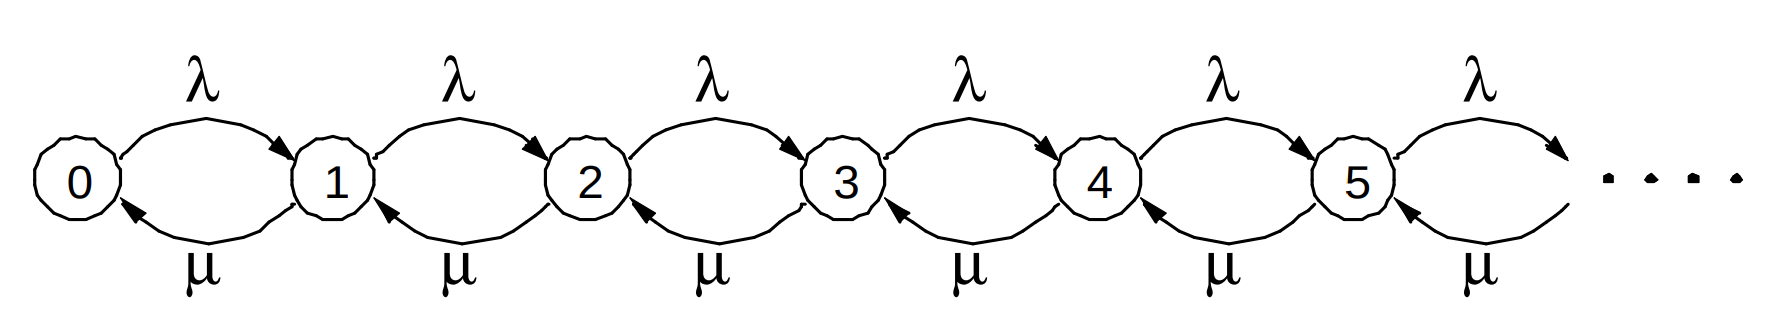

Em estado estacionário Pi é a probabilidade de se estar no estado i.

Com isso a taxa dos movimentos nas duas direções precisam ser iguais:

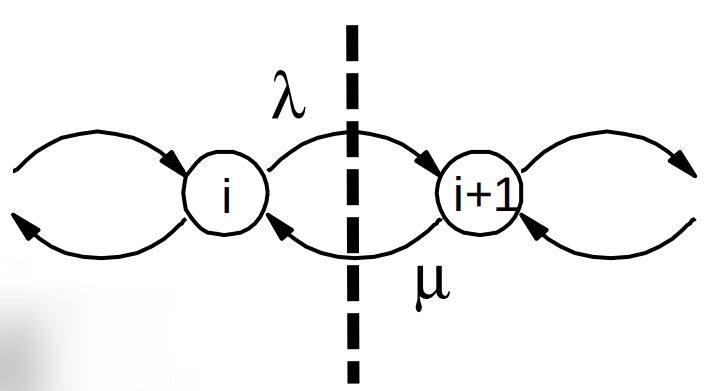

Então temos que λPi = μPi+1

A partir dessa igualdade temos:
* λP0 = μP1
* λP1 = μP2
* λP4 = μP3
\
.\
.\
.\
P1 = λ/μP0 = ρP0
P2 = λ/μP1 = ρ(ρP1) = ρ²P0
\
.\
.\
.\
Pk = ρ^k P0


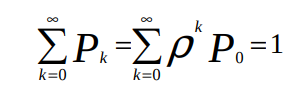

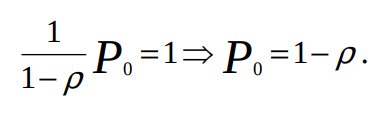

Então a probabilidade de termos n clientes na fila pode ser obtido com:

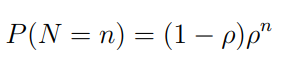

Nos dando a distribuição estacionária:

In [ ]:
rho = 0.1
[(1-rho)*((rho)**n) for n in range(10)]

[0.9,
 0.09000000000000001,
 0.009000000000000003,
 0.0009000000000000002,
 9.000000000000002e-05,
 9.000000000000002e-06,
 9.000000000000004e-07,
 9.000000000000004e-08,
 9.000000000000004e-09,
 9.000000000000004e-10]

##### Por Simulação

             Média  Intervalo de Confiança (limite inferior)  \
Estado 0  0.900098                              8.995527e-01   
Estado 1  0.089928                              8.944319e-02   
Estado 2  0.008976                              8.804382e-03   
Estado 3  0.000905                              8.793402e-04   
Estado 4  0.000082                              7.063391e-05   
Estado 5  0.000010                              2.361696e-06   
Estado 6  0.000002                             -5.247775e-07   

          Intervalo de Confiança (limite superior)  
Estado 0                                  0.900643  
Estado 1                                  0.090413  
Estado 2                                  0.009147  
Estado 3                                  0.000930  
Estado 4                                  0.000093  
Estado 5                                  0.000018  
Estado 6                                  0.000004  


Quantidade de clientes na fila:


Distribuição estacionária c

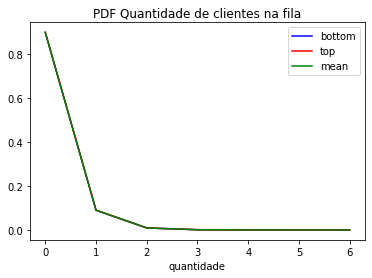

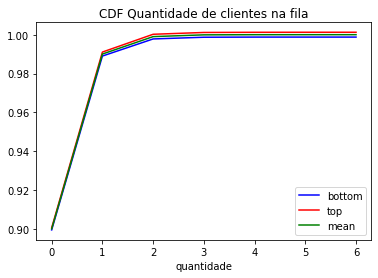



Tempos de espera:

Tempo médio de espera: 95%[0.11025913772268031, 0.11107919879519612], Média: 0.11066916825893822



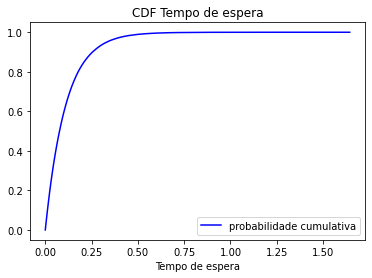

,Média,Intervalo de Confiança (limite inferior),Intervalo de Confiança (limite superior)
Estado 0,0.900098,8.995527e-01,0.900643
Estado 1,0.089928,8.944319e-02,0.090413
Estado 2,0.008976,8.804382e-03,0.009147
Estado 3,0.000905,8.793402e-04,0.000930
Estado 4,0.000082,7.063391e-05,0.000093
Estado 5,0.000010,2.361696e-06,0.000018
Estado 6,0.000002,-5.247775e-07,0.000004


In [ ]:
rounds, _ = getRounds(Lambda=1, Mu=10, system=MM1, maxEvents=100000, roundsQuantity=10)

graphs_from_rounds(rounds)

3) Via cadeia de Markov finita, truncando o tamanho da cadeia (e resolvendo por
método da potência ou eliminação gaussiana). Mostre que a solução obtida via cadeia de Markov está dentro do intervalo de confiança da simulação.

Estime a média do número de clientes no sistema, e o tempo médio de espera, com intervalos de confiança

In [ ]:
# def markov_chain(lambda, mu, chain_size):
lbd = 1
mu = 10
Q = np.array([
      [-lbd, lbd, 0., 0., 0.],
      [mu, -(mu + lbd), lbd, 0., 0.],
      [0.,mu, -(mu + lbd), lbd, 0.],
      [0., 0., mu, -(mu + lbd), lbd],
      [0., 0., 0., mu, -(mu + lbd)]])
np.linalg.solve(Q, [0, 0, 0, 0, 0])

array([ 0.,  0.,  0.,  0., -0.])

In [ ]:
[ 7.58498166e+118, -1.15437699e+119,  5.26647890e+118, -1.59432771e+118,  3.05470908e+117],
[-1.15437699e+120,  1.75687470e+120, -8.01518360e+119, 2.42644651e+119, -4.64903679e+118],
[ 5.26647890e+120, -8.01518360e+120,  3.65667332e+120, -1.10698927e+120,  2.12097560e+119],
[-1.59432771e+121,  2.42644651e+121, -1.10698927e+121, 3.35120241e+120, -6.42085589e+119],
[ 3.05470908e+121, -4.64903679e+121,  2.12097560e+121, -6.42085589e+120,  1.23022681e+120]

[3.05470908e+121,
 -4.64903679e+121,
 2.1209756e+121,
 -6.42085589e+120,
 1.23022681e+120]

##### Por Cadeia de Markov finita

Por ser uma CTMC, então:

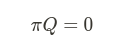

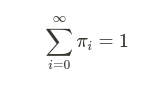

Com Q:

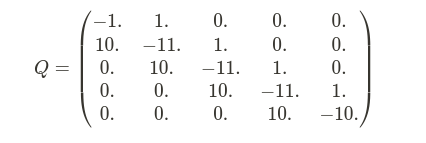

Então:

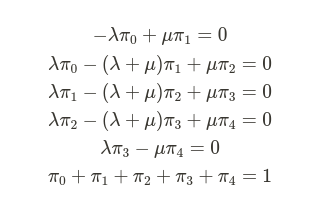

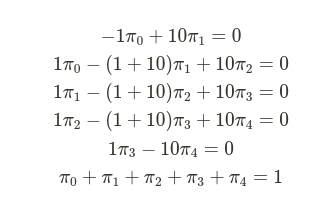

Que nos dá como resultado:

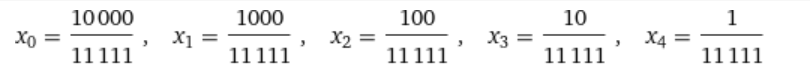

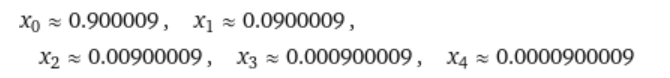

## Q5

### Q5.1


##### M/M/1: ρ = 0.1, λ = 1, µ = 10

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(0.1)}'

'Probabilidade de ter árvores finitas: 0.9'

##### M/M/1: ρ = 0.1, λ = 2, µ = 20

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(0.1)}'

'Probabilidade de ter árvores finitas: 0.9'

##### M/M/1: ρ = 1.2, λ = 12, µ = 10

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(1.2)}'

'Probabilidade de ter árvores finitas: 0'

##### M/M/1: ρ = 2, λ = 20, µ = 10

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(2)}'

'Probabilidade de ter árvores finitas: 0'

##### M/D/1: ρ = 0.1, λ = 1, µ = 10

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(0.1)}'

'Probabilidade de ter árvores finitas: 0.9'

##### M/D/1: ρ = 0.1, λ = 2, µ = 20

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(0.1)}'

'Probabilidade de ter árvores finitas: 0.9'

##### M/D/1: ρ = 1.2, λ = 12, µ = 10

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(1.2)}'

'Probabilidade de ter árvores finitas: 0'

##### M/D/1: ρ = 2, λ = 20, µ = 10

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(2)}'

'Probabilidade de ter árvores finitas: 0'

##### M/D/1: ρ = 0.9, λ = 9, µ = 10

In [ ]:
f'Probabilidade de ter árvores finitas: {probabilityToRemainFiniteTrees(0.9)}'

'Probabilidade de ter árvores finitas: 0.09999999999999998'

### Q5.2

#### Função para pegar as métricas de interesse das árvores

In [ ]:
def get_tree_stats(trees,df_timeline):

  meanDegreeList = []
  maxDegreeMeanList = []
  rootMeanDegreeList = []
  meanRootHeightList = []
  meanVerticesHeightList = []
  busyPeriodMeanTimeList = []
  clientsServedByBusyPeriodMeanList = []

  for tree, df in zip(trees,df_timeline):
    meanDegreeList.append(meanDegree(tree))
    maxDegreeMeanList.append(maxDegreeMean(tree))
    rootMeanDegreeList.append(rootMeanDegree(tree))
    meanRootHeightList.append(meanRootHeight(tree))
    meanVerticesHeightList.append(meanVerticesHeight(tree))
    busyPeriodMeanTimeList.append(busyPeriodMeanTime(tree,df))
    clientsServedByBusyPeriodMeanList.append(clientsServedByBusyPeriodMean(tree))

  meanDegreeConfidence = mean_confidence_interval(meanDegreeList)
  maxDegreeMeanConfidence = mean_confidence_interval(maxDegreeMeanList)
  rootMeanDegreeConfidence = mean_confidence_interval(rootMeanDegreeList)
  meanRootHeightConfidence = mean_confidence_interval(meanRootHeightList)
  meanVerticesHeightConfidence = mean_confidence_interval(meanVerticesHeightList)
  busyPeriodMeanTimeConfidence = mean_confidence_interval(np.array(busyPeriodMeanTimeList))
  clientsServedByBusyPeriodMeanConfidence = mean_confidence_interval(clientsServedByBusyPeriodMeanList)

  wrapper = [meanDegreeConfidence,maxDegreeMeanConfidence,rootMeanDegreeConfidence,
             meanRootHeightConfidence,meanVerticesHeightConfidence,busyPeriodMeanTimeConfidence,
             clientsServedByBusyPeriodMeanConfidence]
  return wrapper

#### Casos avaliados

##### M/M/1: ρ = 0.1, λ = 1, µ = 10

In [ ]:
rounds, tree = getRounds(Lambda=1, Mu=10, system=MM1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

Grau médio de saida: 0.09920188437687538 intervalo de confiança [0.09585119486977246,0.1025525738839783]
Média do grau máximo de saída: 0.09977930574101859 intervalo de confiança [0.09578904470724706,0.10376956677479013]
Grau médio de saída da raiz: 0.09924631126948402 intervalo de confiança [0.09519005171219024,0.10330257082677781]
Altura Média das árvores: 0.10015700627134069 intervalo de confiança [0.09632932084515651,0.10398469169752488]
Média de altura dos nós das árvores: 0.10034198439687939 intervalo de confiança [0.09644269081661244,0.10424127797714633]
Média de duração do período ocupado: 0.11125989339052142 intervalo de confiança [0.10975163487258298,0.11276815190845986]
Média de clientes servidos por periodo ocupado: 1.11015077723955 intervalo de confiança [1.106005911077198,1.114295643401902]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


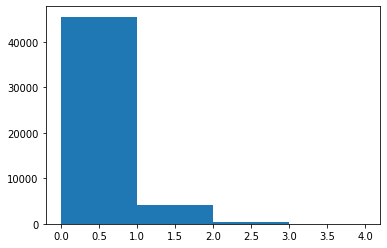

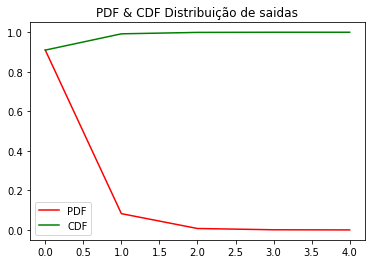

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

##### M/M/1: ρ = 0.1, λ = 2, µ = 20

In [ ]:
rounds, tree = getRounds(Lambda=2, Mu=20, system=MM1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

Grau médio de saida: 0.10051999999999998 intervalo de confiança [0.09666242664058643,0.10437757335941354]
Média do grau máximo de saída: 0.10152947594603604 intervalo de confiança [0.0974765394713854,0.10558241242068667]
Grau médio de saída da raiz: 0.1006616179527138 intervalo de confiança [0.09663205932062226,0.10469117658480535]
Altura Média das árvores: 0.1007062581211624 intervalo de confiança [0.09672855423373433,0.10468396200859048]
Média de altura dos nós das árvores: 0.10069999999999998 intervalo de confiança [0.09682124309831658,0.10457875690168339]
Média de duração do período ocupado: 0.05544311501322846 intervalo de confiança [0.05483987403921032,0.0560463559872466]
Média de clientes servidos por periodo ocupado: 1.1117853970300469 intervalo de confiança [1.1070252063597288,1.116545587700365]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


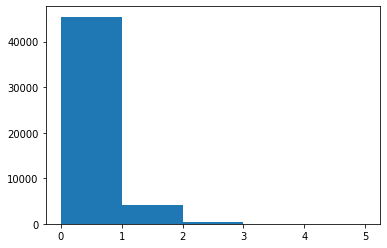

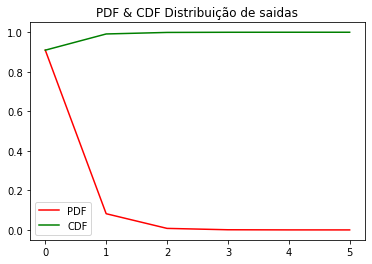

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

##### M/M/1: ρ = 1.2, λ = 12, µ = 10

In [ ]:
rounds, tree = getRounds(Lambda=12, Mu=10, system=MM1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: ignored

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

##### M/M/1: ρ = 2, λ = 20, µ = 10

In [ ]:
rounds, tree = getRounds(Lambda=20, Mu=10, system=MM1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

##### M/D/1: ρ = 0.1, λ = 1, µ = 10

In [ ]:
rounds, tree = getRounds(Lambda=1, Mu=10, system=MD1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

##### M/D/1: ρ = 0.1, λ = 2, µ = 20

In [ ]:
rounds, tree = getRounds(Lambda=2, Mu=20, system=MD1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

##### M/D/1: ρ = 1.2, λ = 12, µ = 10

In [ ]:
rounds, tree = getRounds(Lambda=12, Mu=10, system=MD1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

##### M/D/1: ρ = 2, λ = 20, µ = 10

In [ ]:
rounds, tree = getRounds(Lambda=20, Mu=10, system=MD1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

In [ ]:
rounds, tree = getRounds(Lambda=9, Mu=10, system=MD1, maxEvents=10_000, roundsQuantity=10)
confidences = get_tree_stats(tree,rounds[1])

In [ ]:
print(f'Grau médio de saida: {confidences[0][0]} intervalo de confiança [{confidences[0][1]},{confidences[0][2]}]')
print(f'Média do grau máximo de saída: {confidences[1][0]} intervalo de confiança [{confidences[1][1]},{confidences[1][2]}]')
print(f'Grau médio de saída da raiz: {confidences[2][0]} intervalo de confiança [{confidences[2][1]},{confidences[2][2]}]')
print(f'Altura Média das árvores: {confidences[3][0]} intervalo de confiança [{confidences[3][1]},{confidences[3][2]}]')
print(f'Média de altura dos nós das árvores: {confidences[4][0]} intervalo de confiança [{confidences[4][1]},{confidences[4][2]}]')
print(f'Média de duração do período ocupado: {confidences[5][0]} intervalo de confiança [{confidences[5][1]},{confidences[5][2]}]')
print(f'Média de clientes servidos por periodo ocupado: {confidences[6][0]} intervalo de confiança [{confidences[6][1]},{confidences[6][2]}]')

tree_graphs_from_rounds(rounds,tree)

## Q6

#### MCMC

In [ ]:
# def proposal(actual, vsSum, m):
  # if f(actual, vsSum, m) == 0:
  #   return np.random.choice(np.arange(0.05, 1, 0.05))

#   if actual == 0:
#     return actual + 0.05

#   if actual == 1:
#     return actual - 0.05

#   return np.random.choice([actual - 0.05, actual + 0.05])

# def f(x, vsSum, m):
#   return np.power(x, vsSum)*np.power(1-x, m)

# def ratio(x0, x1, vsSum, m):


# def ratio(x0, x1, vsSum, m):
#   if m < 900:
#     fProposal = f(x1, vsSum, m)
#     fBefore = f(x0, vsSum, m)
#     if(fBefore == 0 and fProposal != 0):
#       return 2
#     elif(fProposal == 0):
#       return 0

#     return fProposal/fBefore


#   mPart = (1 - x1)/(1 - x0)
#   vPart = x1/x0

#   if mPart > 1 and vPart > 1:
#     return 2

#   mPart = np.power(mPart, m/1000)
#   vPart = np.power(vPart, vsSum/1000)

#   if mPart == 0 or vPart == 0:
#     return 0

#   result = np.power(mPart * vPart, 1000)

#   return result

# def acceptance(before, prop, vsSum, m):
#   a = ratio(before, prop, vsSum, m)

#   return a > np.random.random()

# def acceptance(before, proposal, vsSum, m):

#   a = ratio(before, proposal, vsSum, m)

#   return a > np.random.random()


# def metropolis_hastings(quantity, vs, m):
#   samples = []
#   for i in range(1000):
#     vsSum = sum(vs)
#     initval = 0.05 if i % 2 else 0.95

#     actual = initval
#     for j in range(round(quantity/1000)):
#       before = actual

#       newProposal = proposal(before, vsSum, m)

#       if acceptance(before, newProposal, vsSum=vsSum, m=m):
#         samples.append(newProposal)
#       else:
#         samples.append(before)
#   return samples


def metropolis_hastings(quantity, vs, m):
  samples = []
  vsSum = sum(vs)
  step = 0.05

  for i in range(1000):
    actual = 0.5
    nxt = 0
    for i in range(200):
      nxt = np.random.choice([actual - step, actual + step])
      if nxt <= 0 or nxt >= 1:
        acc = 0
      else:
        acc = np.power(nxt/actual, vsSum/1000)*np.power((1-nxt)/(1-actual), m/1000)
        if acc > 1:
          actual = acc
          continue
        acc = np.power(acc, 1000)
      if acc > np.random.random():
          actual = nxt

      samples.append(actual)
  return samples




In [ ]:
# import warnings
def MCMC(Vis):
  # warnings.filterwarnings('ignore')
  m = len(Vis)
  samples = metropolis_hastings(100000, Vis, m)

  print(f'M: {m} Vs: {sum(Vis)}\n')
  print(f'Média: {np.mean(samples)} Variância: {np.var(samples)}\n')

  samples = np.array(samples)
  samples.sort()
  # print(samples)
  X, PDF = np.unique(samples, return_counts=True)
  # print(X, PDF)
  PDF = PDF/sum(PDF)
  # print(PDF, sum(PDF))

  # PDF = list(map(lambda x: f(x, sum(Vis), m), samples))
  plt.title("PDF")
  plt.plot(X, PDF, color='blue')
  plt.xlabel("rho")
  plt.grid(True)
  plt.show()

  CDF = np.cumsum(PDF)
  plt.plot(X, CDF, color='green')
  plt.title("CDF")
  plt.xlabel("rho")
  plt.grid(True)
  plt.show()

In [ ]:
timeline_df = timeline_to_dataframe(MM1(1, 10, 16000)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])

MCMC(Vis)

#### Q6.1

##### Derivação da equação de distribuição do número de clientes deixados para trás, por cada partida.

A probabilidade de se ter n clientes em uma fila após a saída de um cliente pode ser obtida da seguinte forma:



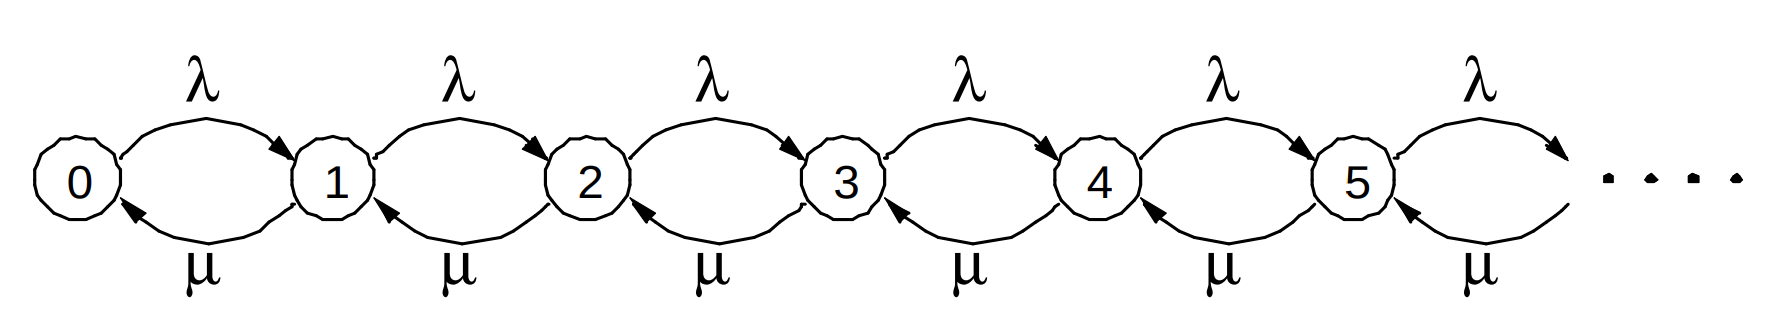

Em estado estacionário Pi é a probabilidade de se estar no estado i.

Com isso a taxa dos movimentos nas duas direções precisam ser iguais:

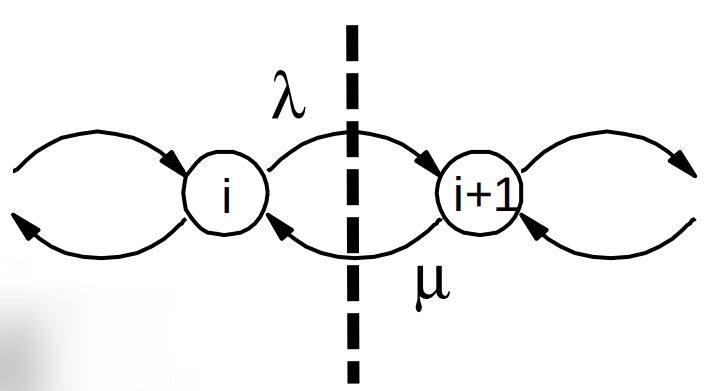

Então temos que λPi = μPi+1

A partir dessa igualdade temos:
* λP0 = μP1
* λP1 = μP2
* λP2 = μP3
\
.\
.\
.\
P1 = λ/μP0 = ρP0
P2 = λ/μP1 = ρ(ρP1) = ρ²P0
\
.\
.\
.\
Pk = ρ^k P0


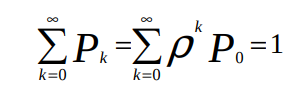

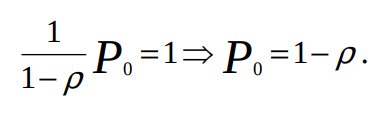

Então:

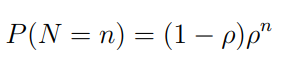

##### Teste para λ = 1 e μ = 10

In [ ]:
timeline_df = timeline_to_dataframe(MM1(1, 10, 400)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])

MCMC(Vis)

##### Verificando eficiência do MCMC para encontrar ρ com diferentes quantidades de eventos e sistemas originais com diferentes ρ

In [ ]:
N = 10
possibleNEvents = [200*k for k in range(1, 6)]
rhosVariance = []
rhosMean = []
for nEvents in possibleNEvents:
  mciSamples = []
  for i in range(1, N):
    totalSamples = []
    for j in range(100):
      timeline_df = timeline_to_dataframe(MM1(i, N, nEvents)[2])
      Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])

      m = len(Vis)
      totalSamples += metropolis_hastings(1000, Vis, m)

    mciSamples.append((np.mean(totalSamples), np.var(totalSamples)))

  rhosVariance.append(list(map(lambda x: x[1],mciSamples)))
  rhosMean.append(list(map(lambda x: x[0],mciSamples)))

X = [i/N for i in range(1, N)]

legends = list(map(lambda x: f'{x} eventos' ,possibleNEvents))

plt.plot(X, rhosMean[0], color='tab:blue')
plt.plot(X, rhosMean[1], color='tab:orange')
plt.plot(X, rhosMean[2], color='tab:green')
plt.plot(X, rhosMean[3], color='tab:red')
plt.plot(X, rhosMean[4], color='tab:purple')

plt.title("Média rho estimado por MCMC")
plt.xlabel("rho real")
plt.legend(legends)
plt.grid(True)
plt.show()


plt.plot(X, rhosVariance[0], color='tab:blue')
plt.plot(X, rhosVariance[1], color='tab:orange')
plt.plot(X, rhosVariance[2], color='tab:green')
plt.plot(X, rhosVariance[3], color='tab:red')
plt.plot(X, rhosVariance[4], color='tab:purple')


plt.title("Variância rho estimado por MCMC")
plt.xlabel("rho real")
plt.legend(legends)
plt.grid(True)
plt.show()


Em relação ao tamanho do trace, podemos ver que quanto maior, mais instaveis são os resultados. Isso é devido a função de avaliação que é baseada na pdf:

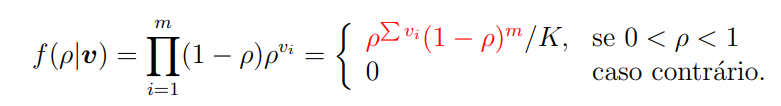

Podemos ver que o ρ e (1 - ρ) estarão sendo elevados a números extremamente altos,e como 0 < ρ < 1, o resultado é levado a um número muito proximo de 0 o que nos leva a enfrentar problemas de precisão. Para traces maiores que 2000, todos os resultados se tornam 0.

O mesmo pode ser observado com o ρ, que passamos a obter resultados consideravelmente mais imprecisos quando o ρ fica maior que 0,5. Isso faz sentido pois filas com ρ mais próximos de 1, mas menores que 1, levam mais tempo para entrarem em seu estado estacionário e como não podemos ter traces muito grandes para estimar o ρ, acabamos utilizando um trace transiente na estimativa, tornando os resultados imprecisos.


#### Q6.2

##### a) m = 100, y = SUM(vi) = 25

In [ ]:
m = 100
y = [1 if i < 25 else 0 for i in range(m) ]

MCMC(y)

##### b) m = 100, y = SUM(vi) = 1000

In [ ]:
m = 100
y = [1 for i in range(m) ]

MCMC(y)

##### c) ρ = 4/5

In [ ]:
timeline_df = timeline_to_dataframe(MM1(4, 5, 400)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])

MCMC(Vis)

##### d) ρ = 1/2

In [ ]:
timeline_df = timeline_to_dataframe(MM1(1, 2, 400)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])

MCMC(Vis)

##### Mais casos

###### M/M/1 ρ = 1/5

In [ ]:
timeline_df = timeline_to_dataframe(MM1(1, 5, 400)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])
print(len(Vis), sum(Vis))
MCMC(Vis)

###### M/M/1 ρ = 2/5

In [ ]:
timeline_df = timeline_to_dataframe(MM1(2, 5, 400)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])
print(len(Vis), sum(Vis))
MCMC(Vis)

###### M/D/1 ρ = 1/5

In [ ]:
timeline_df = timeline_to_dataframe(MD1(1, 5, 400)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])

print(f'm:{len(Vis)}, Soma dos Vs:{sum(Vis)}')

MCMC(Vis)

###### M/D/1 ρ = 2/5

In [ ]:
timeline_df = timeline_to_dataframe(MD1(2, 5, 400)[2])
Vis = list(timeline_df.loc[timeline_df['EventType']=='Service']['QueueSizeAfterEvent'])

print(f'm:{len(Vis)}, Soma dos Vs:{sum(Vis)}')

MCMC(Vis)